## Exploring the GPCP data set missing values

In [105]:
import xarray as xr
import numpy as np
from os.path import expanduser
home = expanduser("~")
import skimage.measure as skm
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeat

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

In [106]:
def plot_snapshot(var, cmap, variable_name, model):
    projection = ccrs.PlateCarree(central_longitude=180)
    lat = var.lat
    lon = var.lon

    f, ax = plt.subplots(subplot_kw=dict(projection=projection), figsize=(15, 5))

    var.plot(transform=ccrs.PlateCarree(), cbar_kwargs={'orientation': 'horizontal','pad':0.125, 'aspect':50,'fraction':0.055}, cmap=cmap)
    ax.add_feature(cfeat.COASTLINE)
    ax.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
    ax.set_title(variable_name + ' snapshot, model:' + model)
    ax.set_xticks([-180, -90, 0, 90, 180])
    ax.set_xticklabels([0, 90, 180, 270, 360])
    ax.set_yticks([-20, 0, 20])
    plt.tight_layout()

In [107]:
folder = home + '/Documents/data/obs/ds'
# folder = '/g/data/k10/cb4968/data/obs/GPCP'
fileName = 'GPCP_precip_raw.nc'
path = folder + '/' + fileName
ds = xr.open_dataset(path)
ds

<xarray.Dataset>
Dimensions:  (lat: 71, lon: 360, time: 9343)
Coordinates:
  * lat      (lat) float32 -35.0 -34.0 -33.0 -32.0 -31.0 ... 32.0 33.0 34.0 35.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) datetime64[ns] 1996-10-01 1996-10-02 ... 2022-04-30
Data variables:
    precip   (time, lat, lon) float32 ...

In [108]:
precip = ds.precip
precip

<xarray.DataArray 'precip' (time: 9343, lat: 71, lon: 360)>
[238807080 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -35.0 -34.0 -33.0 -32.0 -31.0 ... 32.0 33.0 34.0 35.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) datetime64[ns] 1996-10-01 1996-10-02 ... 2022-04-30
Attributes:
    long_name:      NOAA Climate Data Record (CDR) of Daily GPCP Satellite-Ga...
    standard_name:  lwe_precipitation_rate
    units:          mm/day
    valid_range:    [  0. 100.]
    cell_methods:   area: mean time: mean
    coordinates:    time latitude longitude

#### Setting a range of [0, 10000] excludes numbers in the order of e+33

In [109]:
valid_range = [0, 10000] # dataset says valid range 0,100, but does not seem to be stated by GPCP
precip = precip.where((precip >= valid_range[0]) & (precip <= valid_range[1]), np.nan)

#### some days are all zeros, so we make them nan and then exclude days with all nans

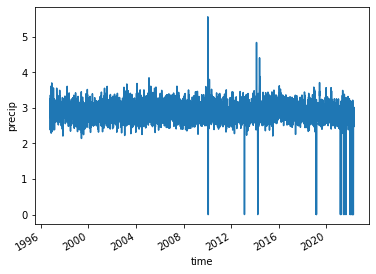

In [110]:
precip.mean(dim = ('lat', 'lon')).plot()

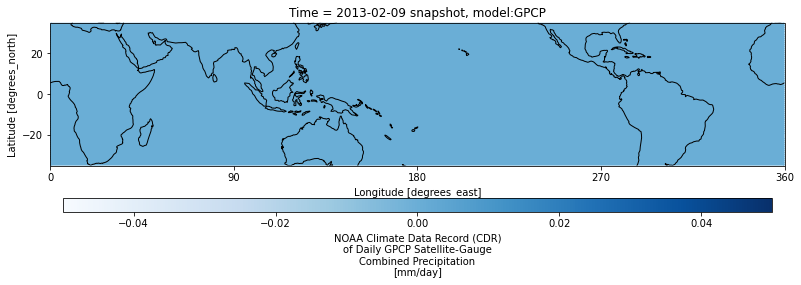

In [111]:
time_test = '2013-02-09'
plot_snapshot(precip.sel(time=time_test), 'Blues', "Time = " + time_test,'GPCP')

In [112]:
precip = precip.where(precip.sum(dim =('lat','lon')) != 0, np.nan)

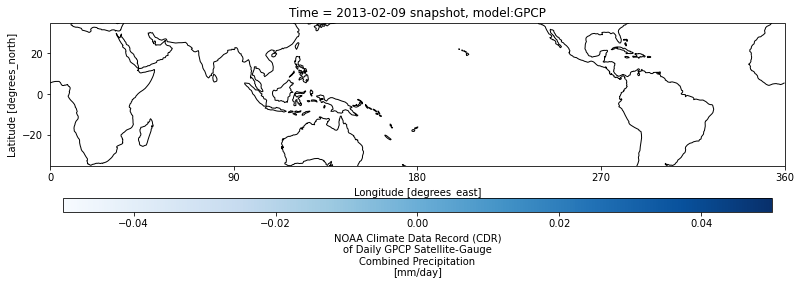

In [113]:
time_test = '2013-02-09'
plot_snapshot(precip.sel(time=time_test), 'Blues', "Time = " + time_test,'GPCP')

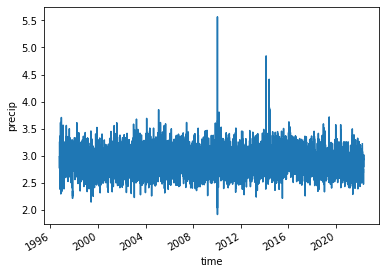

In [114]:
precip.mean(dim = ('lat', 'lon')).plot()

In [115]:
precip = precip.dropna('time', how='all')

In [116]:
# time_test = '2013-02-09'
# plot_snapshot(precip.sel(time=time_test), 'Blues', "Time = " + time_test,'GPCP')

#### one day is almost all nan

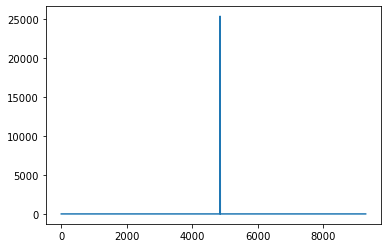

In [117]:
nb_nan = precip.isnull().sum(dim=('lat', 'lon'))
plt.plot(nb_nan)

In [118]:
threshold = 0.5
precip = precip.where(precip.isnull().sum(dim=('lat','lon'))/(precip.shape[1]*precip.shape[2]) < threshold, other=np.nan)

In [119]:
precip = precip.dropna('time', how='all')

#### there are some values that are anomalouss (precipiation rates in the order of 1000) (set range to 250)

In [120]:
(precip > 250).sum().values

array(22)

In [121]:
np.sort(precip.values.flatten())[-50:]

array([ 177.14119,  177.63707,  178.13126,  178.25415,  178.59096,
        178.7734 ,  179.5763 ,  179.93747,  180.30067,  180.7888 ,
        181.05753,  183.01814,  184.59824,  184.68253,  185.0011 ,
        188.87772,  190.14854,  190.76006,  195.6903 ,  201.06107,
        203.13046,  206.2705 ,  210.70753,  215.9421 ,  219.59258,
        222.25842,  236.90428,  246.41144,  263.25052,  274.57025,
        275.93082,  299.65448,  324.76172,  330.74554,  368.1727 ,
        423.67694,  491.0421 ,  512.9324 ,  552.5309 ,  586.0325 ,
        598.6664 ,  621.5313 ,  819.6517 ,  823.9937 ,  883.8219 ,
        999.5709 , 1173.4381 , 1353.7328 , 1605.5956 , 2252.7998 ],
      dtype=float32)

In [122]:
valid_range = [0, 250]
precip = precip.where((precip >= valid_range[0]) & (precip <= valid_range[1]), np.nan)

#### this leaves some days with nan values - linearly interpolate remaining missing values

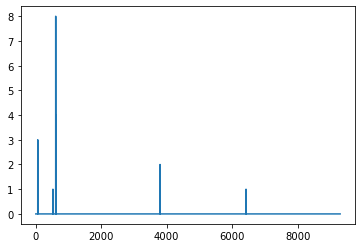

In [123]:
nb_nan = precip.isnull().sum(dim=('lat', 'lon'))
plt.plot(nb_nan)

In [124]:
nan_days =np.nonzero(nb_nan.data)[0]
print(nan_days)
print(len(nan_days))

[  60  523  608  613  618 3795 6419]
7


In [125]:
# print(precip.sel(time='2010-03-01').max(dim=('lat','lon'))) # need to set large valid ragge for this

In [126]:
# precip.sel(time='2010-03-01').sel(lat=slice(-30,-20), lon=slice(90,180)).plot() # with valid range 100, there are multiple missing values this day

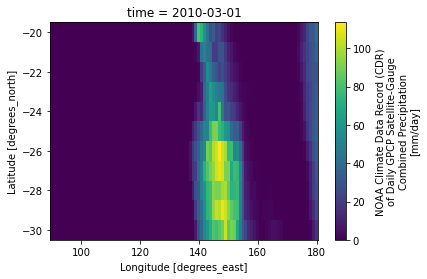

In [127]:
precip.sel(time='2010-03-01').sel(lat=slice(-30,-20), lon=slice(90,180)).plot() #valid range 250

In [128]:
# print(precip.sel(time='2014-05-23').max(dim=('lat','lon'))) # with 10 000 valid range

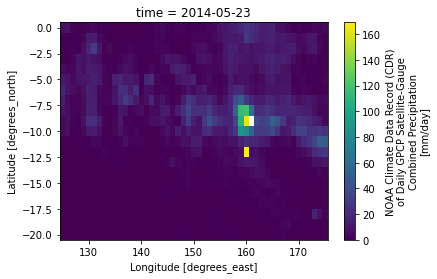

In [129]:
precip.sel(time='2014-05-23').sel(lat=slice(-20,0),lon=slice(125,175)).plot() # before interpolating

In [130]:
from scipy.interpolate import griddata

for day in nan_days:
    time_slice = precip.isel(time=day)
    nan_indices = np.argwhere(np.isnan(time_slice.values))
    nonnan_indices = np.argwhere(~np.isnan(time_slice.values))
    interpolated_values = griddata(nonnan_indices, time_slice.values[~np.isnan(time_slice.values)], nan_indices, method='linear')
    time_slice.values[nan_indices[:, 0], nan_indices[:, 1]] = interpolated_values

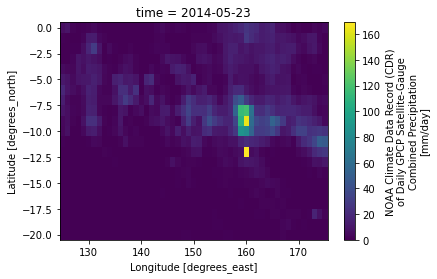

In [131]:
precip.sel(time='2014-05-23').sel(lat=slice(-20,0),lon=slice(125,175)).plot() # after interpolating

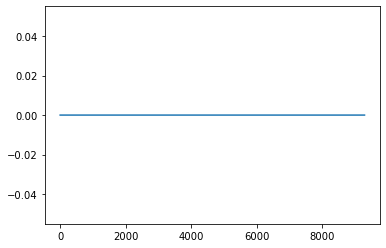

In [132]:
nb_nan = precip.isnull().sum(dim=('lat', 'lon'))
plt.plot(nb_nan)

### exploring peaks

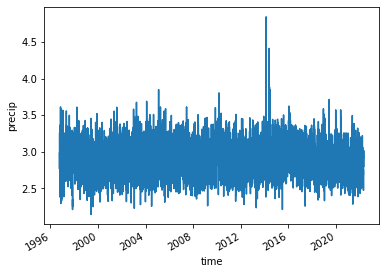

In [133]:
precip.mean(dim = ('lat', 'lon')).plot()

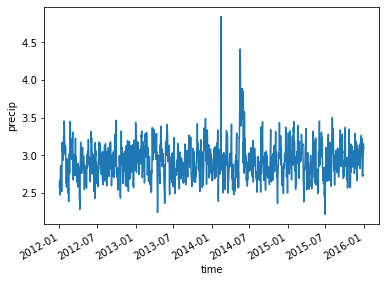

In [134]:
precip.sel(time=slice('2012-01-01', '2016-01-01')).mean(dim = ('lat', 'lon')).plot()

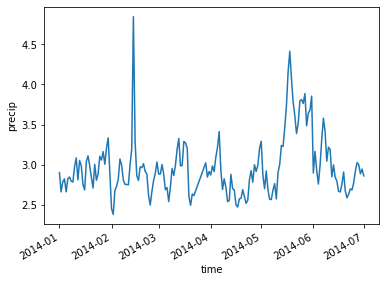

In [135]:
precip.sel(time=slice('2014-01-01', '2014-07-01')).mean(dim = ('lat', 'lon')).plot()

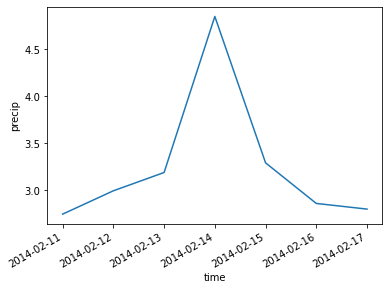

In [136]:
precip.sel(time=slice('2014-02-11', '2014-02-17')).mean(dim = ('lat', 'lon')).plot()

In [137]:
# precip_section = precip.sel(time=slice('2014-02-12', '2014-02-18'))

# for i in np.arange(0, len(precip_section.time.values)):
#     plot_snapshot(precip.isel(time=i), 'Blues', "Time = " + str(precip_section.coords['time'].values[i])[:10],'GPCP')

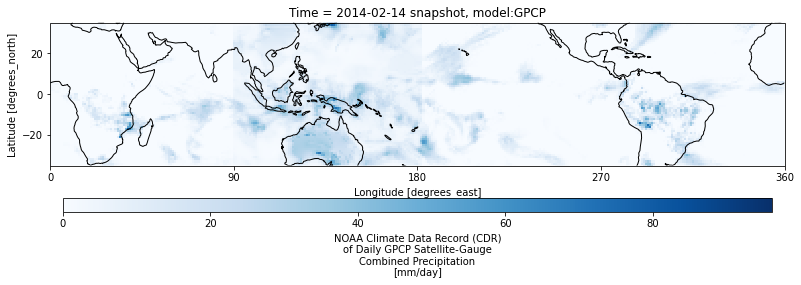

In [138]:
time_test = '2014-02-14'
plot_snapshot(precip.sel(time=time_test), 'Blues', "Time = " + time_test,'GPCP')

In [139]:
precip.sel(time=time_test).mean(dim=('lat','lon'))

<xarray.DataArray 'precip' ()>
array(4.844234, dtype=float32)
Coordinates:
    time     datetime64[ns] 2014-02-14

In [140]:
np.sort(precip.sel(time=time_test).values.flatten())[-50:]

array([49.184208, 49.9542  , 50.416492, 50.725304, 50.739704, 50.980785,
       51.323265, 51.473953, 51.56937 , 51.660843, 51.706715, 51.71601 ,
       52.06079 , 52.765762, 52.91799 , 53.316807, 53.41661 , 54.364937,
       54.787083, 55.24814 , 55.65631 , 56.023148, 56.17202 , 56.190285,
       56.261147, 56.768883, 58.045933, 58.480606, 59.256443, 59.65784 ,
       60.439053, 61.520195, 64.28086 , 64.498055, 65.216934, 65.98826 ,
       66.08043 , 66.44141 , 66.45409 , 69.2095  , 72.48324 , 73.204216,
       73.71301 , 75.0904  , 77.6453  , 78.8654  , 81.004326, 81.9803  ,
       89.52314 , 96.18045 ], dtype=float32)

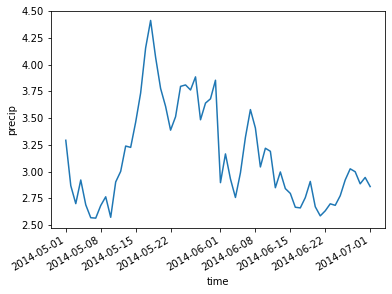

In [141]:
precip.sel(time=slice('2014-05-01', '2014-07-01')).mean(dim = ('lat', 'lon')).plot()

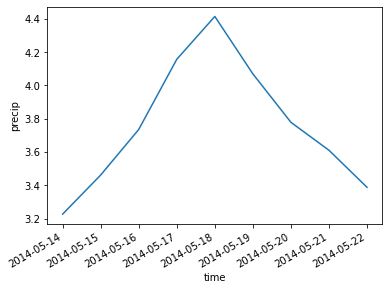

In [142]:
precip.sel(time=slice('2014-05-14', '2014-05-22')).mean(dim = ('lat', 'lon')).plot()

In [143]:
# precip_section = precip.sel(time=slice('2014-05-14', '2014-05-22'))

# for i in np.arange(0, len(precip_section.time.values)):
#     plot_snapshot(precip.isel(time=i), 'Blues', "Time = " + str(precip_section.coords['time'].values[i])[:10],'GPCP')

In [144]:
time_test = '2014-05-18'
precip.sel(time=time_test).mean(dim=('lat','lon'))

<xarray.DataArray 'precip' ()>
array(4.4125237, dtype=float32)
Coordinates:
    time     datetime64[ns] 2014-05-18

In [145]:
np.sort(precip.sel(time=time_test).values.flatten())[-50:]

array([ 68.77369 ,  69.376144,  69.555695,  69.558395,  69.59669 ,
        70.096886,  70.17539 ,  70.26014 ,  70.36388 ,  70.36481 ,
        70.58224 ,  70.690956,  71.081665,  71.102196,  71.30892 ,
        72.22693 ,  72.426575,  72.45823 ,  73.24515 ,  73.528824,
        74.12131 ,  75.23135 ,  75.33197 ,  75.45765 ,  75.80493 ,
        78.64749 ,  78.79509 ,  78.956955,  79.29534 ,  80.3236  ,
        80.63632 ,  80.791084,  82.3413  ,  82.36064 ,  82.434494,
        82.49712 ,  83.723274,  83.795525,  84.900925,  90.21701 ,
        90.423004,  90.97766 ,  91.65599 ,  92.383446,  93.0323  ,
        93.448685,  94.56749 , 103.64985 , 103.860016, 110.61785 ],
      dtype=float32)

## first-order conservative regridding with numpy

In [146]:
def regrid_conserv_np(M_in, M_out):

    # dimensions
    dlat = M_in.lat.data[1]-M_in.lat.data[0]
    dlon = M_in.lon.data[1]-M_in.lon.data[0]
    latBnds = (M_in.lat.data-(dlat/2), M_in.lat.data+(dlat/2))
    lonBnds = (M_in.lon.data-(dlon/2), M_in.lon.data+(dlon/2))
    lat = np.mean(latBnds, axis=0)
    lon = np.mean(lonBnds, axis=0)
    # area of gridboxes as fraction of earth surface area
    area_wlat = np.cos(np.deg2rad(lat))*dlat*np.pi/(4*180^2)

    dlat_n = M_out.lat.data[1]-M_out.lat.data[0]
    dlon_n = M_out.lon.data[1]-M_out.lon.data[0]
    latBnds_n = (M_out.lat.data-(dlat_n/2), M_out.lat.data+(dlat_n/2))
    lonBnds_n = (M_out.lon.data-(dlon_n/2), M_out.lon.data+(dlon_n/2))
    lat_n = np.mean(latBnds_n, axis=0)
    lon_n = np.mean(lonBnds_n, axis=0)



    # weights
    Wlat = np.zeros([len(lat_n), len(lat)])
    for i in np.arange(0,len(lat_n)):
        latBoxMin_n = latBnds_n[0][i]
        latBoxMax_n = latBnds_n[1][i]

        # gridboxes that are atleast partially overlapping with iteration gridbox
        J = (latBnds[0]<=latBoxMax_n)*(latBnds[1]>= latBoxMin_n)*area_wlat

        # including fractional area component contribution
        I = J*(latBnds[1]-latBoxMin_n)/dlat
        K = J*(latBoxMax_n-latBnds[0])/dlat
        II = np.min([I,J,K], axis=0)

        # weights from individual gridboxes contributing to the new gridbox as fraction of the total combined area contribution
        Wlat[i,:] = II/np.sum(II)

    Wlon = np.zeros([len(lon_n), len(lon)])
    for i in np.arange(0,len(lon_n)):
        lonBoxMin_n = lonBnds_n[0][i]
        lonBoxMax_n = lonBnds_n[1][i]

        # gridboxes that are atleast partially overlapping with iteration gridbox
        J = (lonBnds[0]<=lonBoxMax_n)*(lonBnds[1]>= lonBoxMin_n)*1

        # Including fractional area component contribution
        I = J*(lonBnds[1]-lonBoxMin_n)/dlon
        K = J*(lonBoxMax_n-lonBnds[0])/dlon
        L = J*(lonBoxMax_n-lonBnds[0]+360)/dlon
        II = np.min([I,J,K,L], axis=0)

        # weights from individual gridboxes contributing to the new gridbox as fraction of the total combined area contribution
        Wlon[i,:] = II/np.sum(II)



    # interpolation
    M_n = np.zeros([len(M_in.time.data), len(lat_n), len(lon_n)])
    for day in np.arange(0,len(M_in.time.data)):
        M_Wlat = np.zeros([len(lat_n), len(lon)])

        for i in range(0, np.shape(Wlat)[0]):
            M_Wlat[i,:] = np.nansum(M_in.isel(time=day) * np.vstack(Wlat[i,:]),axis=0)/np.sum(~np.isnan(M_in.isel(time=day))*1*np.vstack(Wlat[i,:]),axis=0)
            
        for i in range(0, np.shape(Wlon)[0]):
            M_n[day,:,i] = np.nansum(M_Wlat * Wlon[i,:],axis=1)/np.sum(~np.isnan(M_Wlat)*1*Wlon[i,:], axis=1)

    return M_n

In [147]:
precip

<xarray.DataArray 'precip' (time: 9294, lat: 71, lon: 360)>
array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.24405062e+00, 1.17564774e+00, 5.09209216e-01, ...,
         1.41485035e-01, 2.46518895e-01, 7.92021036e-01],
        [3.70203018e+00, 2.64962578e+00, 1.47164953e+00, ...,
         1.33630061e+00, 1.80621719e+00, 3.90008402e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
...
        [1.68807583e+01, 2.28698769e+01, 2.14786377e+01, ...,
         5.49256206e-02, 1.09845746e+00, 6.20279598e+00],
        [3.60136724e+00, 3.67121553e+00, 4.17802906e+00, ...,
         1.61528194e+00, 4.93976176e-01, 2.31147647e+00],
        [5.38746834e+00, 4.11637926e+00, 1.14184189e+00, ...,
         1.28422987e+00, 4.18579483e+00, 4.60221529e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.33176700e-03, 0.00000000e+00, 0.00000000e+00, ...,
         9.51312780e-01, 1.06344268e-01, 6.69635739e-03],
        ...,
        [0.00000000e+00, 0.00000000e+00, 2.27834597e-01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 3.74256372e-01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.58364609e-01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -35.0 -34.0 -33.0 -32.0 -31.0 ... 32.0 33.0 34.0 35.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) datetime64[ns] 1996-10-01 1996-10-02 ... 2022-04-30
Attributes:
    long_name:      NOAA Climate Data Record (CDR) of Daily GPCP Satellite-Ga...
    standard_name:  lwe_precipitation_rate
    units:          mm/day
    valid_range:    [  0. 100.]
    cell_methods:   area: mean time: mean
    coordinates:    time latitude longitude

In [148]:
path_dsOut= home + '/Documents/data/cmip5/FGOALS-g2/FGOALS-g2_ds_regid_historical.nc'
M_out = xr.open_dataset(path_dsOut)['pr']

In [149]:
precip_n = regrid_conserv_np(precip, M_out)

In [150]:
precip_n

array([[[7.55239169e-01, 8.95194401e-02, 0.00000000e+00, ...,
         2.47540362e-02, 1.12944763e-01, 1.03099534e-01],
        [2.52706833e+00, 1.92314248e-01, 0.00000000e+00, ...,
         9.79081280e-03, 5.46565755e-01, 2.03175812e+00],
        [1.18156630e-01, 0.00000000e+00, 0.00000000e+00, ...,
         1.64440664e-01, 1.17517986e+00, 1.26629762e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.51987646e-04, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.73282494e-01, 5.22018814e-02, 0.00000000e+00],
        [1.68417048e+00, 3.25884366e-01, 0.00000000e+00, ...,
         9.26034794e-03, 1.44058221e-02, 1.36831139e-01],
        [5.95338387e-01, 

In [151]:
precip_n = xr.DataArray(
    data = precip_n,
    dims = ['time', 'lat', 'lon'],
    coords = {'time': precip.time.data, 'lat': M_out.lat.data, 'lon': M_out.lon.data},
    attrs = precip.attrs
)

In [152]:
precip_n

<xarray.DataArray (time: 9294, lat: 22, lon: 128)>
array([[[7.55239169e-01, 8.95194401e-02, 0.00000000e+00, ...,
         2.47540362e-02, 1.12944763e-01, 1.03099534e-01],
        [2.52706833e+00, 1.92314248e-01, 0.00000000e+00, ...,
         9.79081280e-03, 5.46565755e-01, 2.03175812e+00],
        [1.18156630e-01, 0.00000000e+00, 0.00000000e+00, ...,
         1.64440664e-01, 1.17517986e+00, 1.26629762e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.51987646e-04, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.73282494e-01, 5.22018814e-02, 0.00000000e+00],
        [1.68417048e+00, 3.25884366e-01, 0.00000000e+00, ...,
         9.26034794e-03, 1.44058221e-02, 1.36831139e-01],
        [5.95338387e-01, 1.09531481e-02, 0.00000000e+00, ...,
         2.93814678e-03, 5.32835379e-02, 6.71688335e-02],
...
        [0.00000000e+00, 0.00000000e+00, 9.73170789e-04, ...,
         4.28022927e-02, 1.50202834e-02, 7.70819476e-03],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         8.13453026e-01, 3.08566512e-02, 4.31438840e-04],
        [8.14575380e-01, 3.48845258e-01, 2.41670327e-01, ...,
         1.27866250e+00, 2.09358749e-02, 5.55543553e-01]],

       [[8.41599331e-01, 2.28149259e-01, 0.00000000e+00, ...,
         1.06441233e-01, 5.21612385e-01, 8.50732240e-01],
        [9.72169985e-02, 7.55272866e-02, 0.00000000e+00, ...,
         1.44688185e+00, 2.52335043e+00, 2.78215569e+00],
        [2.93028996e-03, 0.00000000e+00, 0.00000000e+00, ...,
         1.97508027e+00, 1.82521542e+00, 2.61477932e-01],
        ...,
        [0.00000000e+00, 0.00000000e+00, 4.17174750e-03, ...,
         5.46165704e-02, 3.07069093e-02, 0.00000000e+00],
        [4.03572829e-02, 2.15826549e-02, 3.45858746e-02, ...,
         0.00000000e+00, 7.36186179e-04, 2.08808250e-01],
        [0.00000000e+00, 6.08160982e-02, 7.69690293e-03, ...,
         6.53924426e-02, 4.53583655e-02, 0.00000000e+00]]])
Coordinates:
  * time     (time) datetime64[ns] 1996-10-01 1996-10-02 ... 2022-04-30
  * lat      (lat) float64 -29.3 -26.51 -23.72 -20.93 ... 20.93 23.72 26.51 29.3
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Attributes:
    long_name:      NOAA Climate Data Record (CDR) of Daily GPCP Satellite-Ga...
    standard_name:  lwe_precipitation_rate
    units:          mm/day
    valid_range:    [  0. 100.]
    cell_methods:   area: mean time: mean
    coordinates:    time latitude longitude

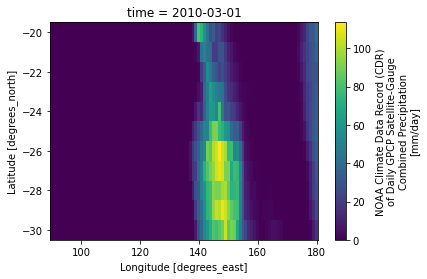

In [153]:
precip.sel(time='2010-03-01').sel(lat=slice(-30,-20), lon=slice(90,180)).plot() #valid range 250

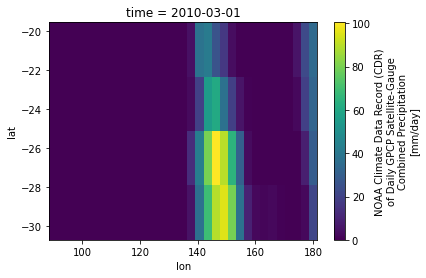

In [154]:
precip_n.sel(time='2010-03-01').sel(lat=slice(-30,-20), lon=slice(90,180)).plot() # 

### saving

In [155]:
import os
def save_file(dataSet, folder, fileName):
    
    os.makedirs(folder, exist_ok=True)
    path = folder + '/' + fileName

    if os.path.exists(path):
        os.remove(path)    
    
    dataSet.to_netcdf(path)

In [156]:
save = True
if save:
    folder = home + '/Documents/data/obs/ds'
    fileName = 'GPCP_precip.nc'
    dataSet = precip_n
    save_file(dataSet, folder, fileName)

In [159]:
save = True
if save:
    folder = home + '/Documents/data/obs/ds'
    fileName = 'GPCP_precip_orig.nc'
    dataSet = precip
    save_file(dataSet, folder, fileName)